In [1]:

#source EPOTFenv/bin/activate (launching and exiting the virtual environment containing the required modules, stored in the working directory)
#EPOTFenv/bin/python your_script.py - for running a script in the virtual environment
#source deactivate

#import all the libraries needed
from import_dep import *

# import my functions stored in the file 'functions' which can then be called with functions.function_name()
import functions



### Plotting and Output Variables 
plot_data = False # set to True to plot the data and export to path_out
powerpoint_data = False # set to True to export the data to a powerpoint presentation and export to path_out
fig_format = 'png' # format of the figure to be saved
plot_transparency = True # set to True to make the data plots transparent


##########TO DO LIST
# change so that if film_thickness == 1 all the functions output the sheet resistance
# and the plots show sheet resistance instead of resistivity
# including the output file names

# check and sort the material title and plotstrings in a way that makes sense for multiple files - perhaps appending them together?



############## End User Defined Variables ##############


## Import Measurement Data 

In [2]:
all_directories = [] # list of all the directories containing the data
dat_raw = [] # list in which each item contains a list for each directory of all the files within it (list of lists)

### First data set
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_JT029_SrRuO3/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[0], film_thickness = 14e-9, material = '$SrRuO_3$', plot_str = 'JT029_SrRuO3'))

### Second data set
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_HC003_BaSnO3/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[1], film_thickness = 100e-9, material = '$BaSnO_3$', plot_str = 'HC003_BaSnO3'))

### Third data set
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_YFW042_HZO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[2], film_thickness = 5e-9, material = '$HfO_2$', plot_str = 'YFW042_HZO'))
    
### Fourth data set
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR004_BSO_LSO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[3], film_thickness = 309e-9, material = '$BaSnO_3/LaScO_3$', plot_str = 'DR004_BSO'))
#BSO layer is 309 nm, LSO layer is 12.9 nm

### Fifth data set
all_directories.append(Path('/Users/horatiocox/Desktop/RUG_Postdoc/Experiments/Electrical/VDP_DR003_BSO_LSO/Data/'))
dat_raw.append(functions.import_ppms_data(all_directories[4], film_thickness = 309e-9, material = '$BaSnO_3/LaScO_3$', plot_str = 'DR003_BSO'))
#BSO layer is 317 nm, LSO layer is 12.7 nm



# Note that fields have been converted to Tesla

File 1 imported: JT029_SrRuO3_171024_Combined with shape (650, 5, 6)
File 2 imported: JT029_SrRuO3_101024_HallRun1 with shape (72, 5, 6)
Error with file: .DS_Store, 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
File 4 imported: JT029_SrRuO3_091024_Halltest2 with shape (68, 5, 6)
File 5 imported: JT029_SrRuO3_171024_Combined_fullrange.txt with shape (850, 5, 6)
Error with file: YFW042_HZO_IV_resistivity.png, 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
File 7 imported: JT029_SrRuO3_191024_Combined4 with shape (8712, 5, 6)
Error with file: .DS_Store, 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
File 2 imported: HC003_BaSnO3_STO_061124_Hall with shape (3024, 5, 6)
Error with file: .DS_Store, 'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte
File 2 imported: YF042_HfO2_STO_071124_Hall_2 with shape (3660, 5, 6)
File 3 imported: YF042_HfO2_STO_071124_Hall_5 with shape (2508, 5, 6)
File 

## Instrument Applied Current Approximation
- Keep below this level to prevent joule heating based off the two terminal resistance

In [3]:

R_approx = (1/1e-4)
a = (1000*R_approx)**(-0.5)
print(f'{a:.1e} A')

3.2e-04 A


## Select Data for Plotting

In [4]:
# First visualise the data contained in each list
for count, dat in enumerate(dat_raw):
    print(f'dat_{count}:', [f'{count_2}={d.filename}' for count_2, d in enumerate(dat)])


# Select the data sets to be plotted and put into a single list
#dat_raw_sel = [dat_raw[4][0],dat_raw[4][1],dat_raw[4][2],dat_raw[4][8]] # DR003
dat_raw_sel = [dat_raw[3][0],dat_raw[3][1], dat_raw[3][2], dat_raw[3][3]] # DR004
#dat_raw_sel = [dat_raw[2][1],dat_raw[2][4],dat_raw[2][5]] 
#dat_raw_sel = [dat_raw[0][4]]
print('dat_raw_sel:', [f'{count}={d.filename}' for count, d in enumerate(dat_raw_sel)])



dat_0: ['0=JT029_SrRuO3_171024_Combined', '1=JT029_SrRuO3_101024_HallRun1', '2=JT029_SrRuO3_091024_Halltest2', '3=JT029_SrRuO3_171024_Combined_fullrange.txt', '4=JT029_SrRuO3_191024_Combined4']
dat_1: ['0=HC003_BaSnO3_STO_061124_Hall']
dat_2: ['0=YF042_HfO2_STO_071124_Hall_2', '1=YF042_HfO2_STO_071124_Hall_5', '2=YF042_HfO2_STO_071124_Hall_7 (conflicted copy 2024-11-18 093018)', '3=YF042_HfO2_STO_071124_Hall_3', '4=YF042_HfO2_STO_071124_Hall_6', '5=YF042_HfO2_STO_071124_Hall_7']
dat_3: ['0=DR001_LaScO3__BaSnO3_STO_201124_test1', '1=DR004_LaScO3__BaSnO3_STO_201124_combined3', '2=DR004_LaScO3__BaSnO3_STO_201124_combined4', '3=DR004_LaScO3__BaSnO3_STO_201124_test2']
dat_4: ['0=DR003_LaScO3__BaSnO3_STO_211124_combined3', '1=DR003_LaScO3__BaSnO3_STO_211124_combined4', '2=DR003_LaScO3__BaSnO3_STO_211124_combined5', '3=DR003_LaScO3__BaSnO3_STO_211124_combined2', '4=DR003_LaScO3__BaSnO3_STO_211124_test2', '5=DR003_LaScO3__BaSnO3_STO_211124_test5', '6=DR003_LaScO3__BaSnO3_STO_211124_test4', '7=

## Extract and Check Temperature, Field, and Current values

In [5]:
# Extract the current, temperature and field values from the data as lists along with the number of values used for each
#ctf = [current_unique, temp_unique, field_unique, current_no, temp_no, field_no]
# Reduced_data = [1,-5] means that the first and last 5 temperature points are removed from the data
# Reduced_temp = [3,-1] will skip the first 3 temperature points and the last 1 temperature point

dat = functions.extract_ctf(dat_raw_sel, Reduced_temp = False, Reduced_current=False)
# Check you have the expected and correct Temperature, Field and Current values!

# Update a single data file with reduced temperature or current values
#dat[2] = functions.extract_ctf([dat_raw_sel[2]], Reduced_temp = [0,-6], Reduced_current=False)[0]




For file: DR001_LaScO3__BaSnO3_STO_201124_test1
11 Currents (uA): [-1000.  -800.  -600.  -400.  -200.     0.   200.   400.   600.   800.
  1000.]
1 Temperatures (K): [300.]
2 Fields (kOe): [0. 0.]
Is this correct?
For file: DR004_LaScO3__BaSnO3_STO_201124_combined3
11 Currents (uA): [-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.]
12 Temperatures (K): [135. 150. 165. 180. 195. 210. 225. 240. 255. 270. 285. 300.]
14 Fields (kOe): [-90. -75. -60. -45. -30. -15.  -0.   0.  15.  30.  45.  60.  75.  90.]
Is this correct?
For file: DR004_LaScO3__BaSnO3_STO_201124_combined4
11 Currents (uA): [-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.]
1 Temperatures (K): [150.]
14 Fields (kOe): [-90. -75. -60. -45. -30. -15.  -0.   0.  15.  30.  45.  60.  75.  90.]
Is this correct?
For file: DR004_LaScO3__BaSnO3_STO_201124_test2
11 Currents (uA): [-10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.   8.  10.]
1 Temperatures (K): [305.]
2 Fields (kOe): [0. 0.]
Is this correct?


## Colormaps

In [6]:
# Create Colormaps and Markers for the data based off the field and temperature values extracted
# Concatenate all d.ctf[1] and d.ctf[2] arrays
all_temps = np.concatenate([d.ctf[1] for d in dat])
all_fields = np.concatenate([d.ctf[2] for d in dat])

# Find the min and max values
min_temp = np.min(all_temps)
max_temp = np.max(all_temps)
min_field = np.min(all_fields)
max_field = np.max(all_fields)

print(f'min_temp={min_temp}, max_temp={max_temp}, min_field={min_field}, max_field={max_field}')
# Generating one set of colors for increasing positive field and one set for decreasing negative field

# Normalize the temperature and field values
norm_temp = Normalize(vmin=min_temp, vmax=max_temp)
norm_field = Normalize(vmin=min_field, vmax=max_field)

# Generate colormaps
cmap_temp = plt.get_cmap('coolwarm') 
cmap_field = plt.get_cmap('coolwarm')

# Example usage: get color for a specific temperature and field value
temp_value = 300  # Example temperature value
field_value = 1.5  # Example field value

color_temp = cmap_temp(norm_temp(temp_value))
color_field = cmap_field(norm_field(field_value))

print(f'Color for temperature {temp_value}: {color_temp}')
print(f'Color for field {field_value}: {color_field}')


# Generate color map for each data set
cmap_dat = plt.get_cmap('plasma')(np.linspace(0, 1, len(dat)))


# Generate a list of markers for the data
mark_p = ['+', 'x', '*', '^', 'v', '<', '>', 'p', 'P', 'o', 'h', 'H', 'X', 'd']

min_temp=135.0, max_temp=305.0, min_field=-8.9999554687, max_field=8.9999757812
Color for temperature 300: (np.float64(0.7468380122117647), np.float64(0.14002101948235293), np.float64(0.17999609695686275), np.float64(1.0))
Color for field 1.5: (np.float64(0.9383263563333333), np.float64(0.8089165520313726), np.float64(0.741161515027451), np.float64(1.0))


## Calculate VDP Resistivity, Magnetoresistance, Hall Coefficient and Hall Mobility


In [7]:
# Extract the resistivity using the VDP method and write to the PPMSData objects in the list "dat"
dat = functions.vdp_resistivity(dat)

# Calculate the magnetoresistance at each temperature and field strength
# mag_res(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = functions.magnetoresistance(dat)

# Calculate the Hall coefficient and mobility
# hall_mobility(temperature, field, index) where: index 0 = VDP config A, index 1 = VDP config B, index 2 = average of A and B
dat = functions.vdp_hall(dat)


/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/functions.py:294: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  R_sheet_B = fsolve(vdp_equation, initial_guess, args=(R_01_23[0], R_13_02[0]))[0]
/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/functions.py:294: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  R_sheet_B = fsolve(vdp_equation, initial_guess, args=(R_01_23[0], R_13_02[0]))[0]
/Users/horatiocox/Desktop/Electronic_properties_of_thin_films/functions.py:291: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  R_sheet_A = fsolve(vdp_equation, initial_guess, args=(R_32_10[0], R_20_31[0]))[0]


## Plot IV data to Check Linearity of Resitivity Measurements

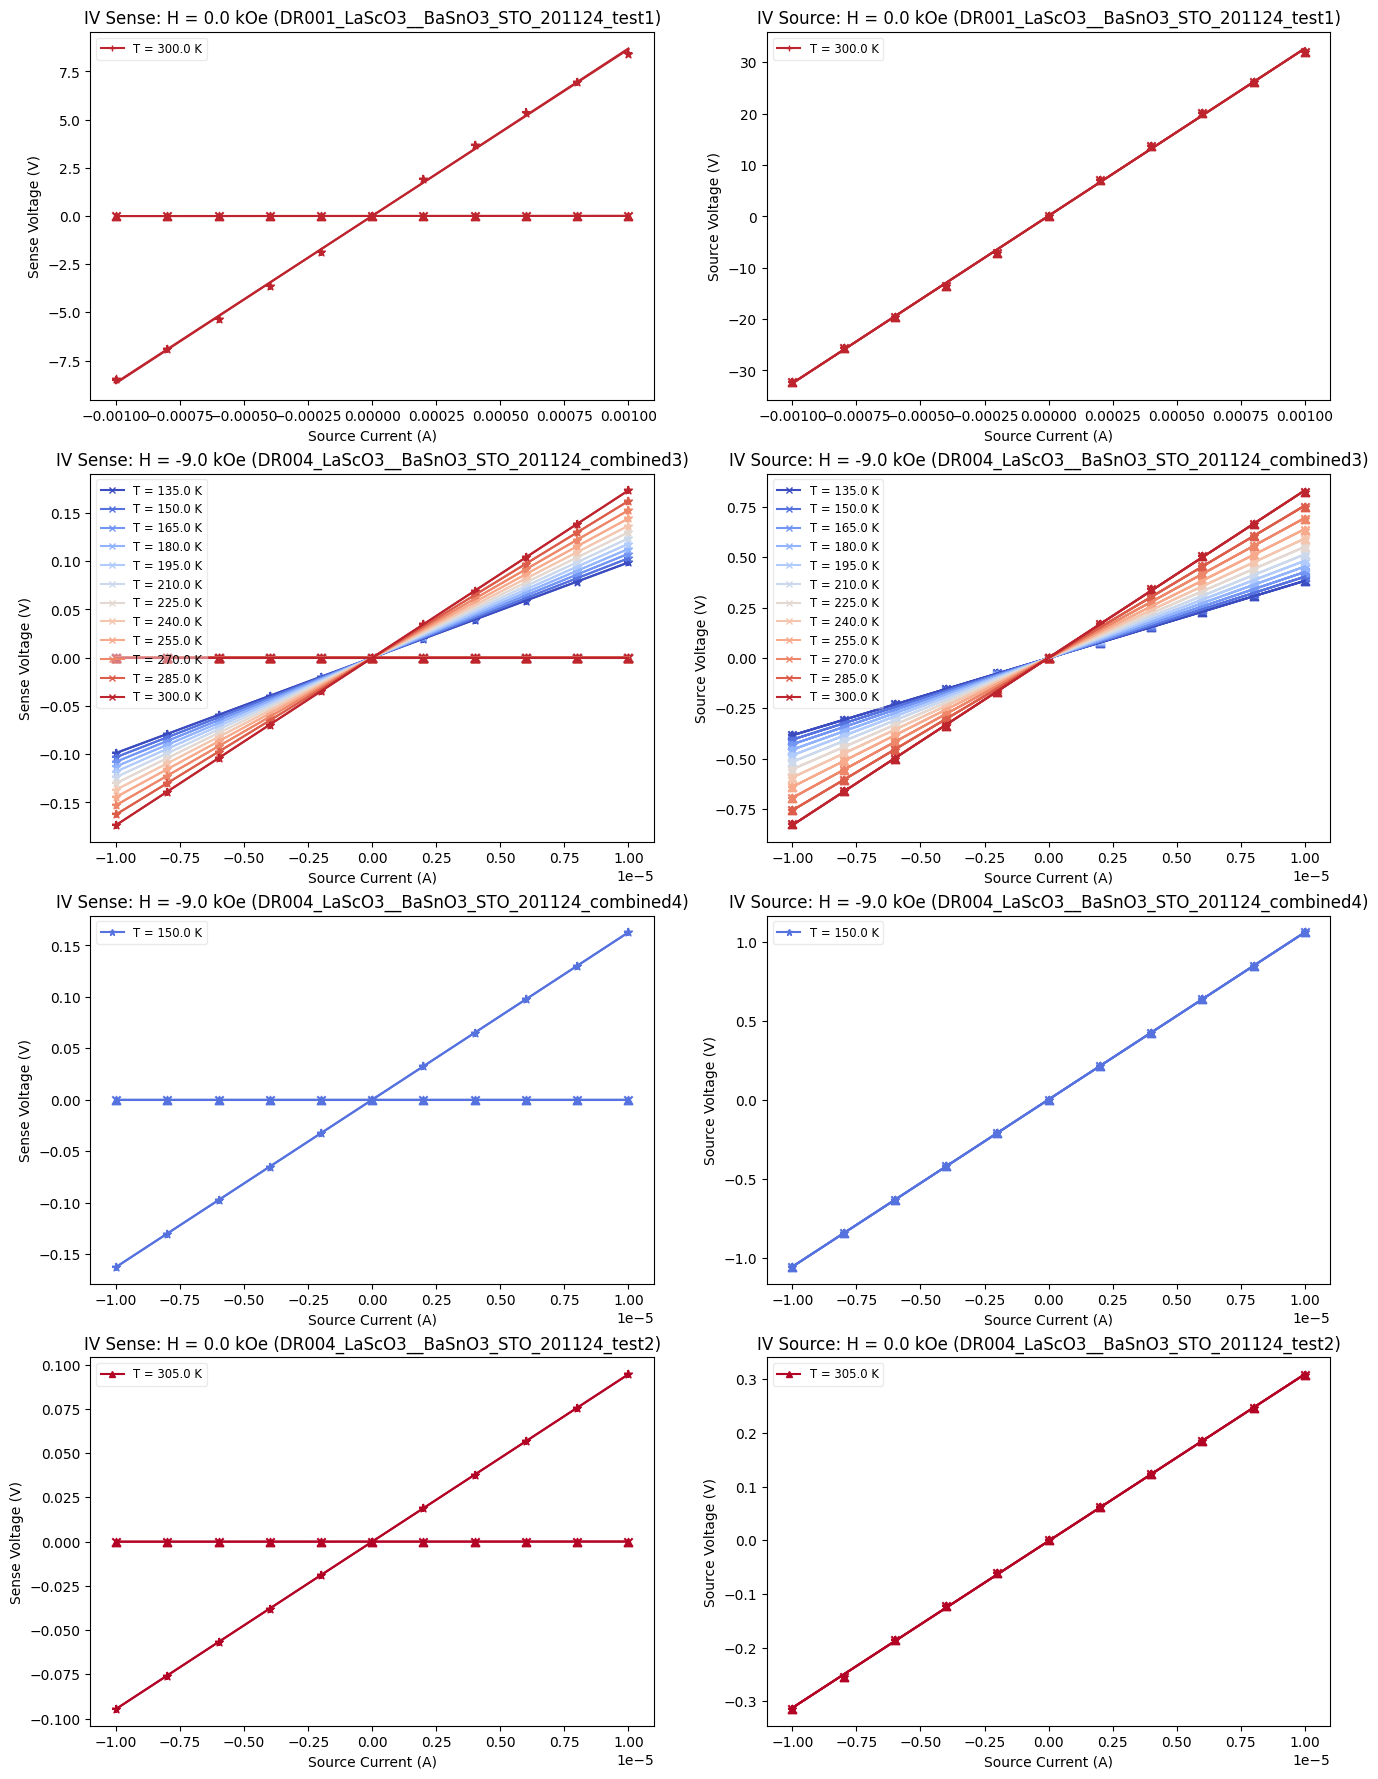

In [8]:
fig1 = plt.figure(figsize=(16, 5.5*len(dat)))
gs = fig1.add_gridspec(len(dat), 2)
labels = ['index_3', 'index_4', 'index_5', 'index_6']
color_s = ['r', 'g', 'b', 'm'] # simple four colors for the 4 configurations of vdp

for j, d in enumerate(dat):
    
    ax = fig1.add_subplot(gs[j, 0])
    ax1 = fig1.add_subplot(gs[j, 1])

    ## Plotting Source(I) vs Sense(V) data

    for t in range(d.ctf[4]):
        counter = t*d.ctf[3]*d.ctf[5] 
        for i in range(4):  
            R_test = linregress(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 4, 2+i])
            ax.scatter(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 4, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax.plot(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], R_test.intercept + R_test.slope * d.data_np[counter:d.ctf[3]+counter, 2, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])))
        
        # Add a dummy plot for the legend entry
        ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')
        
        ax.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax.set_xlabel('Source Current (A)')
    ax.set_ylabel('Sense Voltage (V)')
    ax.set_title(f'IV Sense: H = {np.round(d.data_np[0, 1, 2],decimals=0)} kOe ({d.filename})')


    ## Plotting the Source IV data
    for t in range(d.ctf[4]):
        counter = t*d.ctf[3]*d.ctf[5] 
        for i in range(4):  
            R_test_2 = linregress(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 3, 2+i])
            ax1.scatter(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], d.data_np[counter:d.ctf[3]+counter, 3, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax1.plot(d.data_np[counter:d.ctf[3]+counter, 2, 2+i], R_test_2.intercept + R_test_2.slope * d.data_np[counter:d.ctf[3]+counter, 2, 2+i], color=cmap_temp(norm_temp(d.ctf[1][t])))
        
        # Add a dummy plot for the legend entry
        ax1.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')
        
        ax1.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax1.set_xlabel('Source Current (A)')
    ax1.set_ylabel('Source Voltage (V)')
    ax1.set_title(f'IV Source: H = {np.round(d.data_np[0, 1, 2],decimals=0)} kOe ({d.filename})')

#ax.set_ylim(-0.00005,0.0000)

plt.show()
if plot_data == True:
    fig1.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_resistivity.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## R-squared Analysis to Check Linearity of I-V data

average R-squared for DR001_LaScO3__BaSnO3_STO_201124_test1 = 0.9850017900047732
average R-squared for DR004_LaScO3__BaSnO3_STO_201124_combined3 = 0.7436407599190886
average R-squared for DR004_LaScO3__BaSnO3_STO_201124_combined4 = 0.46931762822942996
average R-squared for DR004_LaScO3__BaSnO3_STO_201124_test2 = 0.9994548854153329


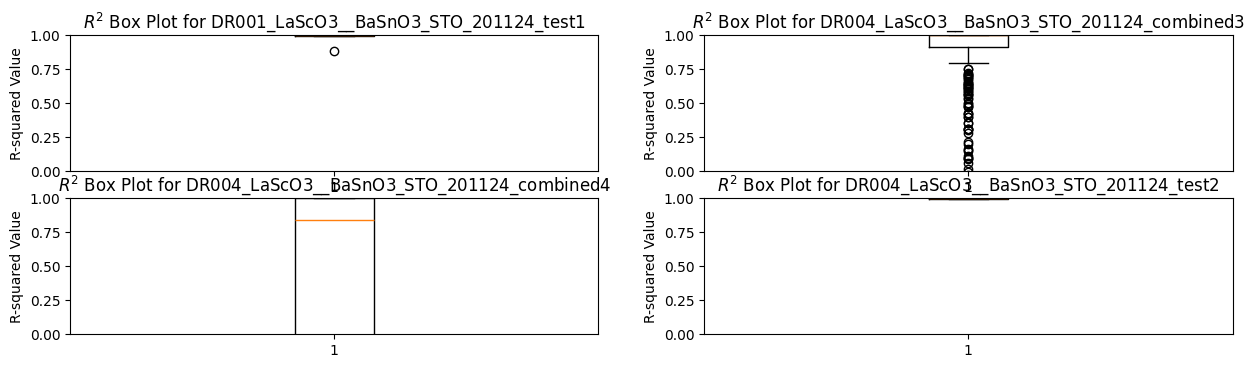

In [9]:
fig2 = plt.figure(figsize=(15, 3*len(dat) // 2))
gs = fig2.add_gridspec(1+len(dat) // 2, 2)

for j, d in enumerate(dat):
    print(f'average R-squared for {d.filename} =', sum(d.R_squared_res) / len(d.R_squared_res))
    ax = fig2.add_subplot(gs[j // 2, j % 2])
    
    # Plot R-square values in a boxplot
    # Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
    ax.boxplot(d.R_squared_res)
    ax.set_title(f'$R^2$ Box Plot for {d.filename}')
    ax.set_ylabel('R-squared Value')
    ax.set_ylim(0, 1)  # If needed, you can set x-axis limits too

plt.show()

if plot_data == True:
    fig2.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_Rsq_boxplot.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Resistivity Configuration Compararison 
Comparing the resistivity in configuration A and B which are inverted versions of one another (e.g. source meter and sense meter swapped positions)
This is a good check for any systematic errors

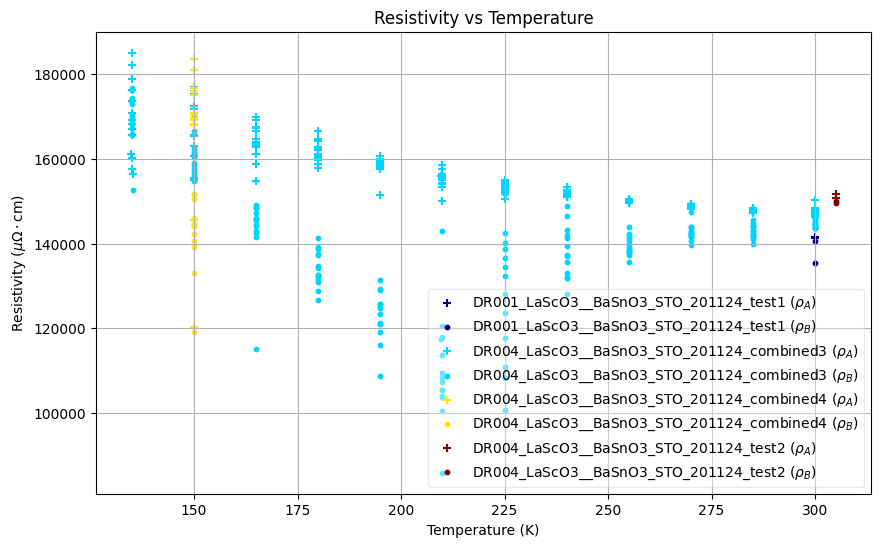

In [10]:
# Create a figure and axis
fig3 = plt.figure(figsize=(10, 6))
ax = fig3.add_subplot(111)  # Create a single subplot

c_val = plt.cm.jet(np.linspace(0,1,len(dat)))

# Loop over the data sets
for j, d in enumerate(dat):
    
    # Plot R_sheet_A vs Temp
    ax.scatter(d.res_data[:,0], d.res_data[:,2] * 1e8, marker='+', color=c_val[j], label=f'{d.filename} ($\\rho_A$)')

    # Plot R_sheet_B vs Temp
    ax.scatter(d.res_data[:,0], d.res_data[:,3] * 1e8, marker='o', s=10, color=c_val[j], label=f'{d.filename} ($\\rho_B$)')

# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Resistivity ($\mu \Omega \cdot$cm)')
ax.set_title('Resistivity vs Temperature')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

#ax.set_xlim(0, 10)
# Show the plot
plt.show()

if plot_data == True:
    fig3.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_A_vs_B.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Resistivity vs Temperature

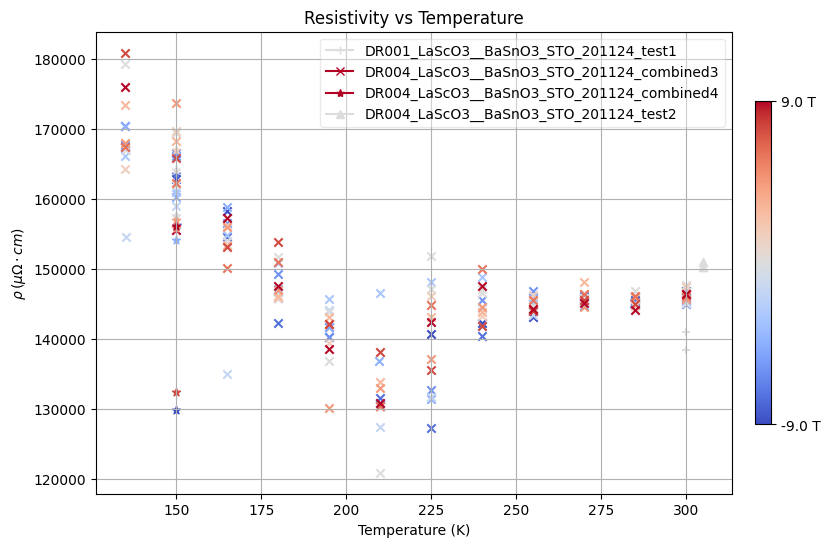

In [11]:
# Create a figure and axis
fig4 = plt.figure(figsize=(10, 6))
ax = fig4.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    for k in range(d.ctf[5]):
        # Plot rho_film vs Temp
        ax.scatter(d.res_data[k::d.ctf[5], 0], d.res_data[k::d.ctf[5], 4] * 1e8, marker=mark_p[j], color=cmap_field(norm_field(d.res_data[k, 1])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_field(norm_field(d.res_data[k, 1])), label=f'{d.filename}')

# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\rho\,(\mu \Omega \cdot cm)$')
ax.set_title(f'Resistivity vs Temperature')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])

#ax.set_ylim(0,10000)
#ax.set_xlim(0, 10)

# Show the plot
plt.show()

if plot_data == True:
    fig4.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


- Anderson localisation causes the metal insulator transition at low T
- If you have defects in film, they can have an external effect of localising charge carriers and reducing the conductivity
    - Also causes loss of metalicity beneath a certain thicknes of LSMO etc
    -  Defects localise the previously delocalised charge carriers, either due to thickness reudction or low T
    - Low thicknes its because number of defects is constant - > higher defect density
    

## Data Filtering on Resistivity Data
- There appear to be outliers where an error is thrown
- This is confirmed by repeat experiments where the spikes in resistivity are not consistent

In [12]:
## Median Filter
filt_kern = 0
if filt_kern != 0:
    for j, d in enumerate(dat):
        for t_count, t in enumerate(d.ctf[1], start=0):  
            
            # Filter the resistivity data    
            res_dat = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4]
            res_dat_filtered = scipy.signal.medfilt(res_dat, kernel_size=filt_kern)
            d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] = res_dat_filtered

            # Filter the Hall data
            index = t_count * d.ctf[5]
            hall_dat = d.hall_data[index:index+d.ctf[5], 6]
            hall_dat_filtered = scipy.signal.medfilt(hall_dat, kernel_size=filt_kern)
            d.hall_data[index:index+d.ctf[5], 6] = hall_dat_filtered
    
    
    # Re-calculate the magnetoresistance after filtering (exclude_res makes sure it doesn't recalculate the resistivity and overwrite the filtering)      
    dat = functions.magnetoresistance(dat, exclude_res=True)
    
## Gaussian Smoothing Filter
filt_sigma = 0
if filt_sigma != 0:
    for j, d in enumerate(dat):
        for t_count, t in enumerate(d.ctf[1], start=0):   
            
            # Filter the resistivity data      
            res_dat = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4]
            res_dat_smoothed = scipy.ndimage.gaussian_filter1d(res_dat, sigma=filt_sigma)
            d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] = res_dat_smoothed
            
            # Filter the Hall data
            index = t_count * d.ctf[5]
            hall_dat = d.hall_data[index:index+d.ctf[5], 6]
            hall_dat_smoothed = scipy.ndimage.gaussian_filter1d(hall_dat,  sigma=filt_sigma)
            d.hall_data[index:index+d.ctf[5], 6] = hall_dat_smoothed
    
    
    # Re-calculate the magnetoresistance after smoothing (exclude_res makes sure it doesn't recalculate the resistivity and overwrite the smoothing)      
    dat = functions.magnetoresistance(dat, exclude_res=True)

## Z-score outlier detection
threshold = 0#1.5  # Z-score threshold for detecting outliers (lower threshold means more points are considered outliers)
if threshold != 0:
    for j, d in enumerate(dat):
        for t_count, t in enumerate(d.ctf[1], start=0):      
            res_dat = d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4]
            
            # Calculate the Z-scores of the data
            z_scores = zscore(res_dat)
            
            # Identify outliers
            outliers = np.abs(z_scores) > threshold
            
            # Replace outliers with interpolated values
            res_dat_filtered = res_dat.copy()
            res_dat_filtered[outliers] = np.interp(np.flatnonzero(outliers), np.flatnonzero(~outliers), res_dat[~outliers])
            
            d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] = res_dat_filtered
    
    # Re-calculate the magnetoresistance after filtering (exclude_res makes sure it doesn't recalculate the resistivity and overwrite the filtering)      
    dat = functions.magnetoresistance(dat, exclude_res=True)

## Resistivity vs H

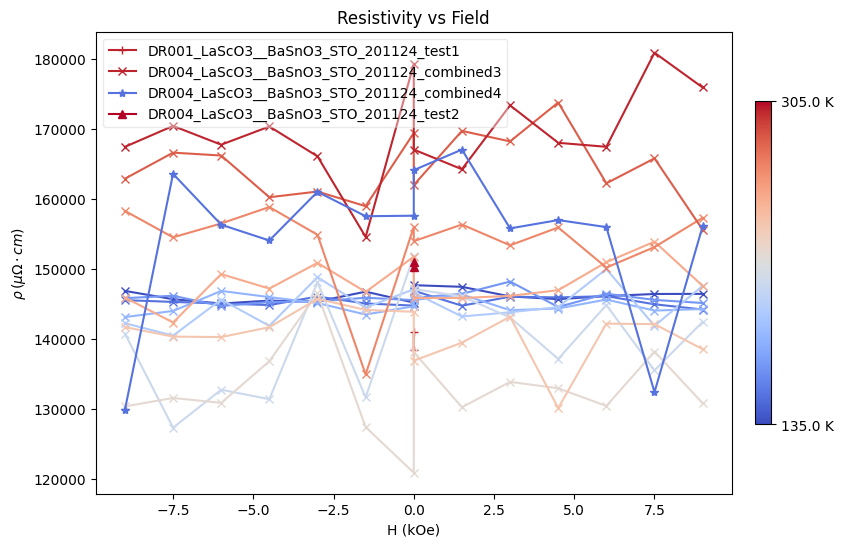

In [13]:
fig5 = plt.figure(figsize=(10, 6 ))
gs = fig5.add_gridspec(1, 1)
ax = fig5.add_subplot(gs[0, 0])

for j, d in enumerate(dat):
    for t_count, t in enumerate(d.ctf[1], start=0):      
            
            ax.plot(d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 1], d.res_data[t_count*d.ctf[5]:(t_count+1)*d.ctf[5], 4] * 1e8, marker=mark_p[j], color=cmap_temp(norm_temp(t)))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(t)), label=f'{d.filename}')
        
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'$\rho\,(\mu \Omega \cdot cm)$')
ax.set_title(f'Resistivity vs Field')
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

#ax.set_ylim(0, 0.05)

plt.show()

if plot_data == True:
    fig5.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_resistivity_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Magnetoresistance vs H
- Plotting the magnetoresistance vs the Applied field strength (H) for several temperatures

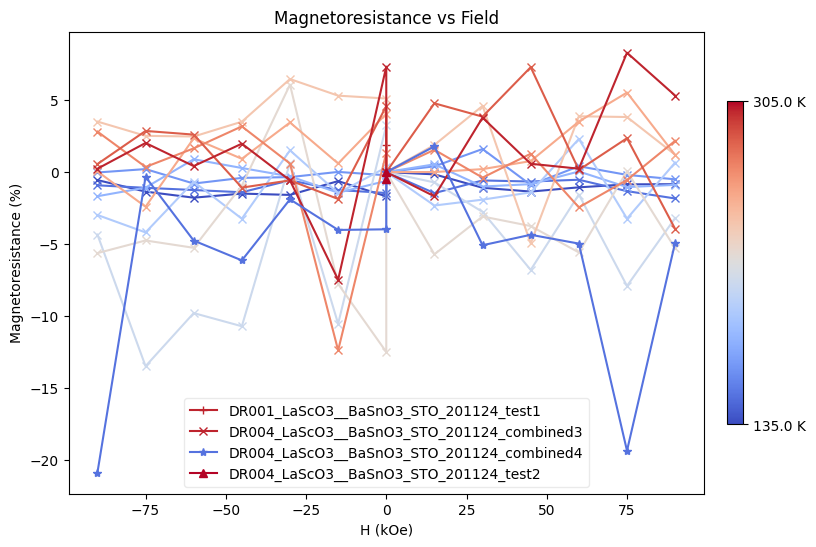

In [14]:
fig6 = plt.figure(figsize=(10, 6 ))
gs = fig6.add_gridspec(1, 1)
ax = fig6.add_subplot(gs[0, 0])

for j, d in enumerate(dat):
    for t_count, t in enumerate(d.ctf[1], start=0):  
        if t > 1:
            # Add a plot of magnetoresistance vs field strength for each loop of temperature (excluding last field point which is repeat of B=0)
            ax.plot(d.ctf[2][:] * 10, d.mag_res[t_count, :, 2], marker=mark_p[j], color=cmap_temp(norm_temp(t)))
            # Plot repeat point of B=0 with an x marker to show the difference between two B=0 points
            # ax.scatter(d.ctf[2][int(d.ctf[5] / 2)] * 10, d.mag_res[t_count, int(d.ctf[5] / 2), 2], marker='x', color=c_val[t_count])
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(t)), label=f'{d.filename}')
        
ax.set_xlabel('H (kOe)')
ax.set_ylabel('Magnetoresistance (%)')
ax.set_title(f'Magnetoresistance vs Field')
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

#ax.set_ylim(-100, 150)

plt.show()

if plot_data == True:
    fig6.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_magnetoresistance_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Magnetoresistance Vs T
- Now looking at how the Magnetoresitance at a set field strength varies over temperature
- Displaying this for VDP configuration A, VDP configuration B and the average of the two

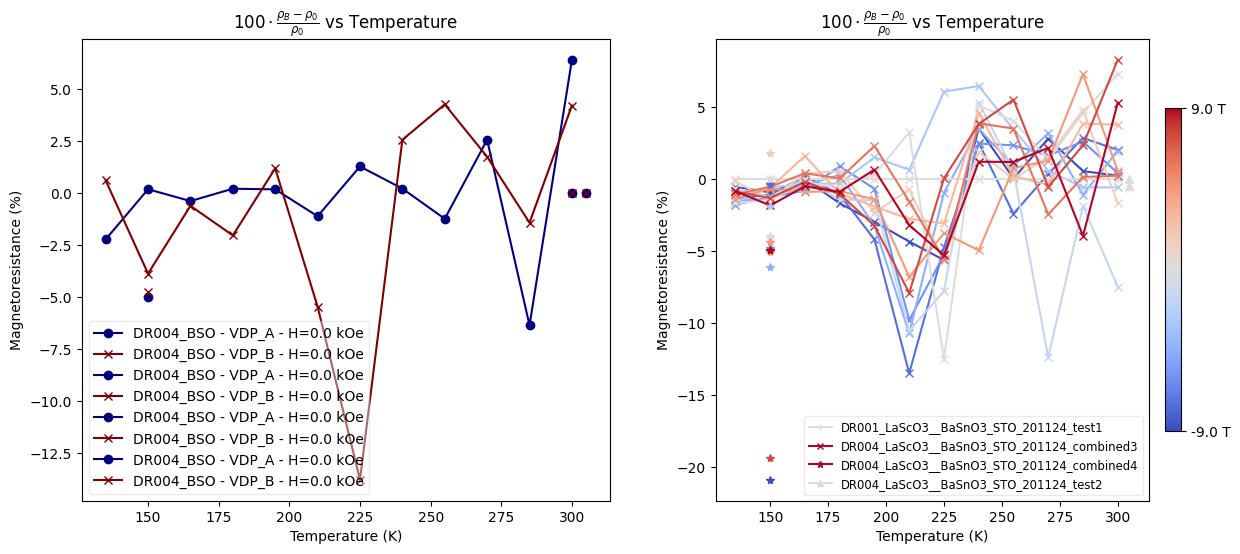

In [15]:
fig7 = plt.figure(figsize=(15, 6))
ax = fig7.add_subplot(121)  # Create two subplots
ax2 = fig7.add_subplot(122)  

# Generating one set of colors for increasing positive field and one set for decreasing negative field
# higher field is brighter color in both cases
cmap1 = plt.get_cmap('jet')(np.linspace(0, 1, int(dat[0].ctf[5] / 2)))
cmap2 = plt.get_cmap('jet_r')(np.linspace(0, 1, int(dat[0].ctf[5] / 2)))
c_val = np.vstack((cmap1, cmap2))





# Sub_plot 1: Comparing configurations A and B
for d in dat:
    # Find the index of the maximum positive field strength
    f_index = int(d.ctf[5]) - 1
    ax.plot(d.ctf[1], d.mag_res[:, f_index, 0], marker='o', color=c_val[0], label=f'{d.plot_str} - VDP_A - H={np.round(d.ctf[2][f_index]/1000, 0)} kOe')
    ax.plot(d.ctf[1], d.mag_res[:, f_index, 1], marker='x', color=c_val[int(len(c_val)/2)], label=f'{d.plot_str} - VDP_B - H={np.round(d.ctf[2][f_index]/1000, 0)} kOe')

ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'Magnetoresistance (%)')
ax.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
ax.legend(loc='best', framealpha=0.4)

# Sub_plot 2: Comparing the average magnetoresistance vs T for various field strengths 
for j, d in enumerate(dat):

    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    cmap1 = plt.get_cmap('jet')(np.linspace(0, 1, int(d.ctf[5] / 2)))
    cmap2 = plt.get_cmap('jet_r')(np.linspace(0, 1, int(d.ctf[5] / 2)))
    c_val = np.vstack((cmap1, cmap2))
    
    for H_count, H in enumerate(d.ctf[2], start=0):
        ax2.plot(d.ctf[1], d.mag_res[:, H_count, 2], marker=mark_p[j], color=cmap_field(norm_field(H)))     
    
    # Add a dummy plot for the legend entry
    ax2.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(H)), label=f'{d.filename}')
        
ax2.set_xlabel('Temperature (K)')
ax2.set_ylabel(r'Magnetoresistance (%)')
ax2.set_title(r'$100 \cdot \frac{\rho_{B} - \rho_{0}}{\rho_{0}}$ vs Temperature')
# Add a legend outside the plot
ax2.legend(loc='lower right', fontsize='small', markerscale=0.8, framealpha=0.4)

#ax2.set_ylim(-10, 100)
#ax2.set_xlim(0, 50)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax2,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])


plt.show()

if plot_data == True:
    fig7.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_magnetoresistance_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Arhenius Plot

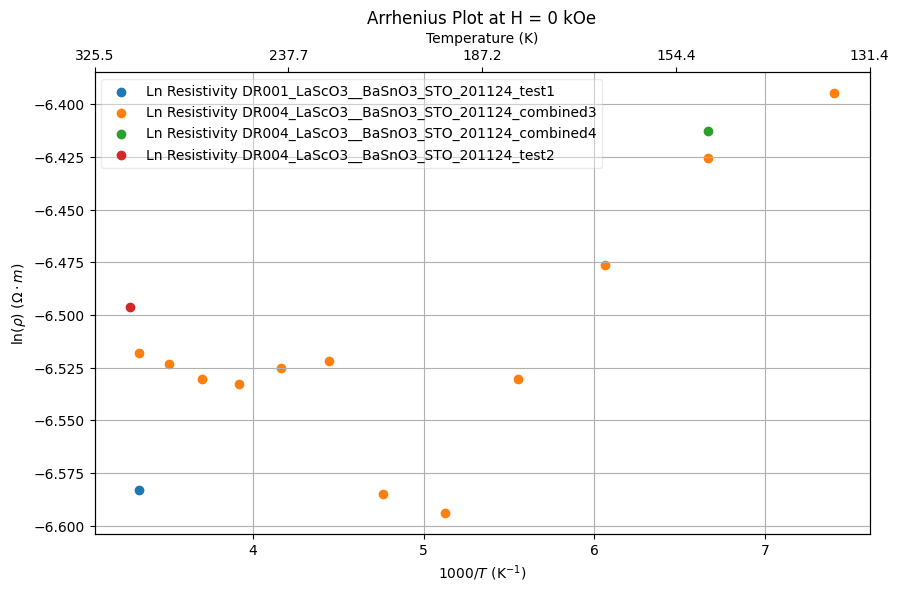

In [16]:
# Create a figure and axis
fig8 = plt.figure(figsize=(10, 6))
ax = fig8.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot rho_film vs 1000/Temp
    ax.scatter(1000 / d.res_data[int(d.ctf[5]/2)::d.ctf[5], 0], np.log(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 4]), marker='o', linestyle='-', label=f'Ln Resistivity {d.filename}')

# Set labels and title
ax.set_xlabel(r'$1000/T$ (K$^{-1}$)')
ax.set_ylabel(r'$\ln(\rho)$ ($\Omega \cdot m$)')
ax.set_title('Arrhenius Plot at H = 0 kOe')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a secondary x-axis at the top
ax2 = ax.twiny()

# Set the limits of the secondary x-axis to match the primary x-axis
ax2.set_xlim(ax.get_xlim())

# Set the ticks and labels for the secondary x-axis
new_ticks = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=5)
ax2.set_xticks(new_ticks)
ax2.set_xticklabels([f'{1000/tick:.1f}' for tick in new_ticks])
ax2.set_xlabel('Temperature (K)')

#ax.set_xlim(0, 20)

# Show the plot
plt.show()

if plot_data == True:
    fig8.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_Arrhenius Plot.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Log(R) vs Log(T)

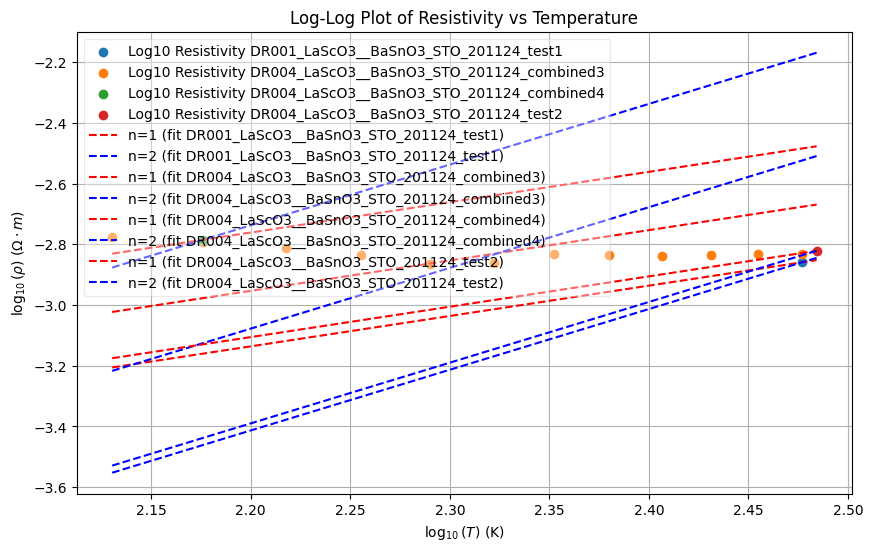

In [17]:
# Create a figure and axis
fig9 = plt.figure(figsize=(10, 6))
ax = fig9.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Plot log10(rho_film) vs log10(Temp)
    ax.scatter(np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 0]), np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 4]), marker='o', linestyle='-', label=f'Log10 Resistivity {d.filename}')

# Set labels and title
ax.set_xlabel(r'$\log_{10}(T)$ (K)')
ax.set_ylabel(r'$\log_{10}(\rho)$ ($\Omega \cdot m$)')
ax.set_title('Log-Log Plot of Resistivity vs Temperature')

# Add lines of n=1 and n=2 with best fit intercepts
x_vals = np.linspace(np.log10(min_temp), np.log10(max_temp), 100)

# Calculate the best fit intercept for n=1
for j, d in enumerate(dat):
    log_T = np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 0])
    log_R = np.log10(d.res_data[int(d.ctf[5]/2)::d.ctf[5], 4])
    
    slope_1 = 1
    intercept_1 = np.mean(log_R - slope_1 * log_T)
    ax.plot(x_vals, slope_1 * x_vals + intercept_1, label=f'n=1 (fit {d.filename})', linestyle='--', color='r')

    slope_2 = 2
    intercept_2 = np.mean(log_R - slope_2 * log_T)
    ax.plot(x_vals, slope_2 * x_vals + intercept_2, label=f'n=2 (fit {d.filename})', linestyle='--', color='b')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Show the plot
plt.show()

if plot_data == True:
    fig9.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_LogR_vs_LogT.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)

## Hall Resistivity ($\rho_{xy}$)
- This is: $\frac{V_{measured-perpendicular}}{I_{source}}*t$


## Plot IV Data to check linearity of Hall measurements

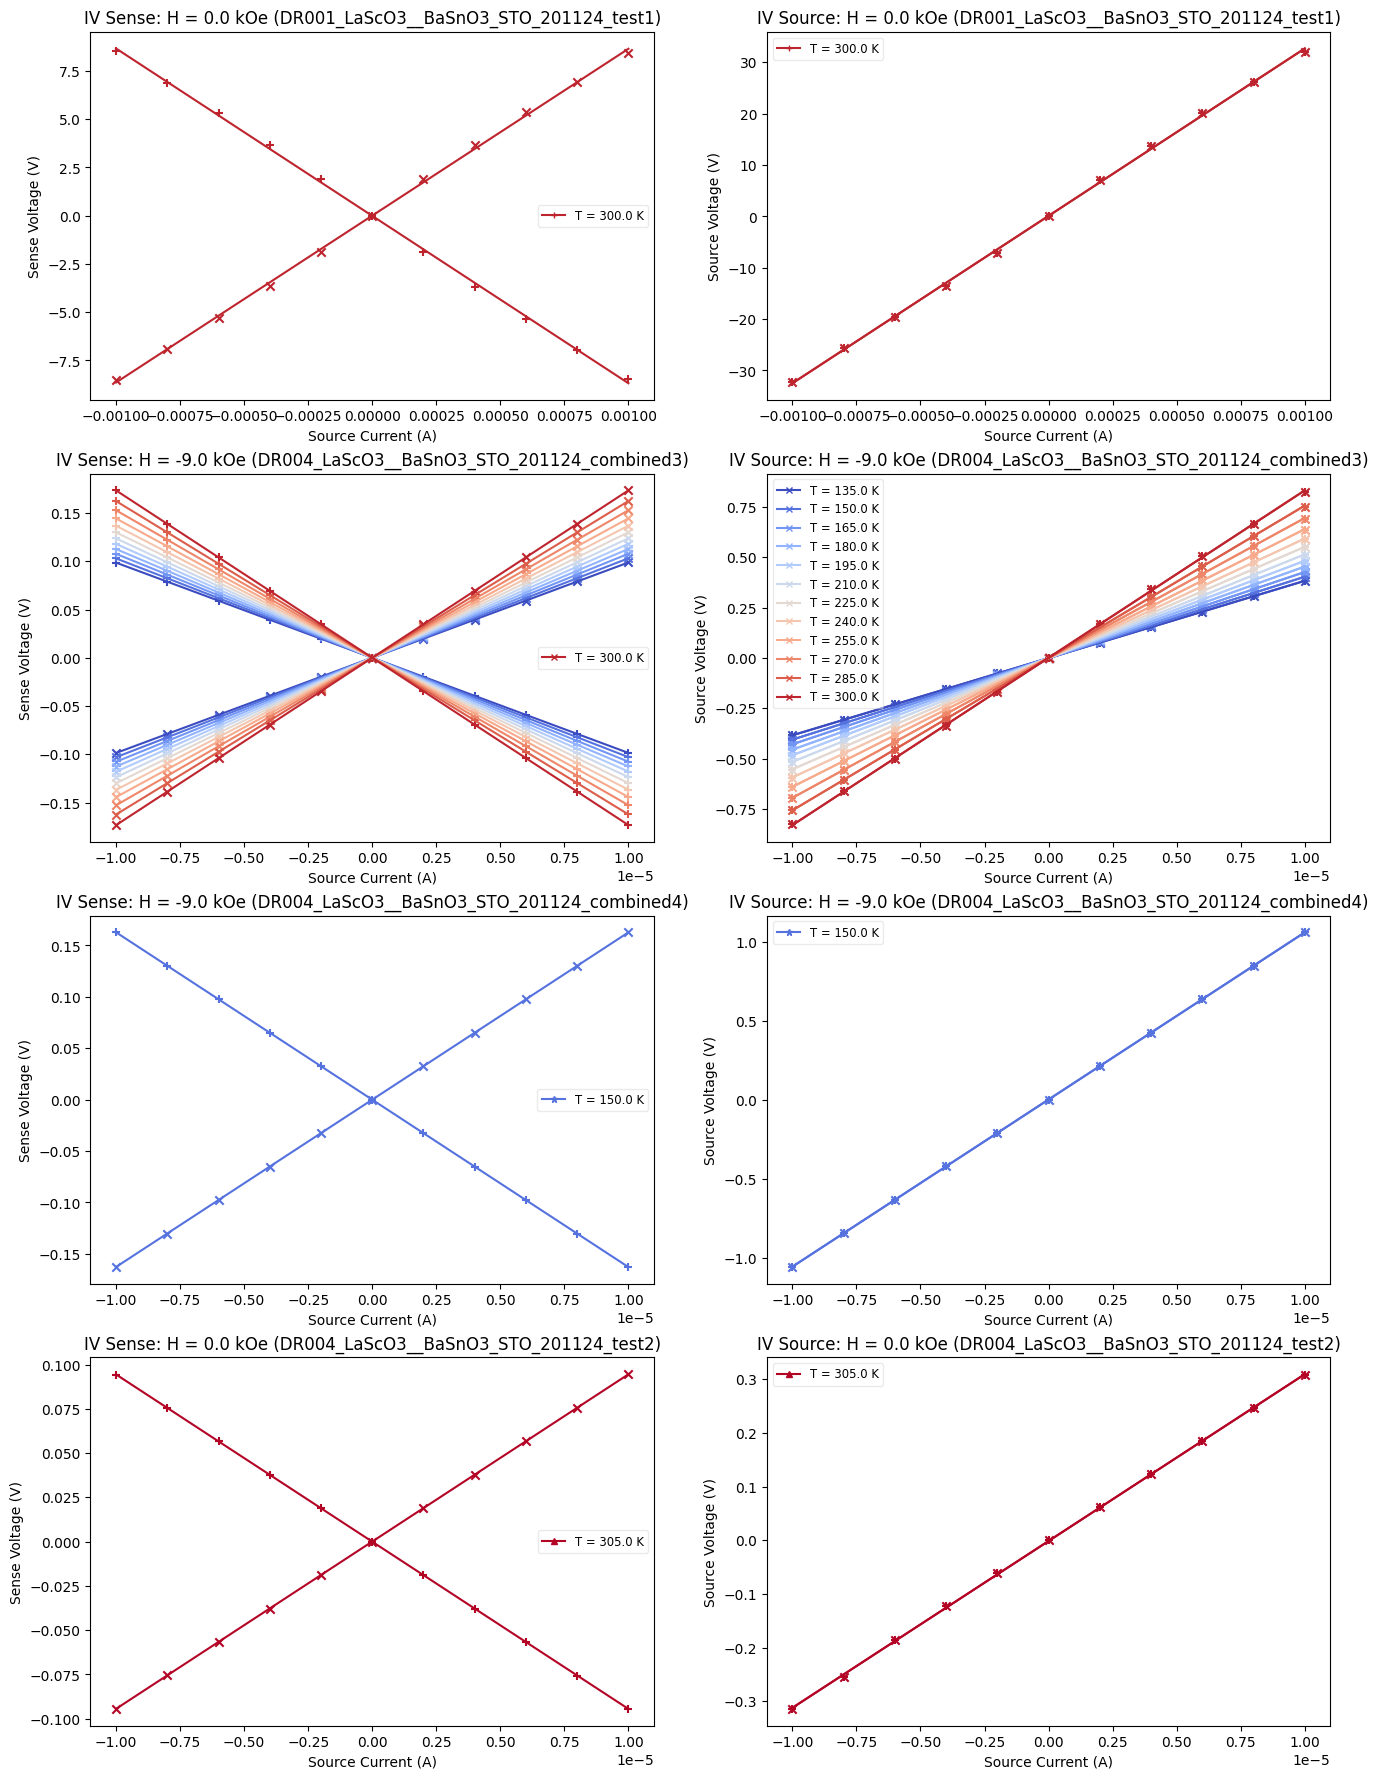

In [18]:
fig10 = plt.figure(figsize=(16, 5.5*len(dat)))
gs = fig10.add_gridspec(len(dat), 2)
labels = ['index_1', 'index_2']
color_s = ['r', 'g', 'b', 'm'] # simple four colors for the 4 configurations of vdp

for j, d in enumerate(dat):
    
    ax = fig10.add_subplot(gs[j, 0])
    ax1 = fig10.add_subplot(gs[j, 1])

    ## Plotting Source(I) vs Sense(V) data
    for t in range(d.ctf[4]):
        counter = t*d.ctf[3]*d.ctf[5] 
        for i in range(2):  
            R_test = linregress(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 4, i])
            ax.scatter(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 4, i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax.plot(d.data_np[counter:d.ctf[3]+counter, 2, i], R_test.intercept + R_test.slope * d.data_np[counter:d.ctf[3]+counter, 2, i], color=cmap_temp(norm_temp(d.ctf[1][t])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')

    ax.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax.set_xlabel('Source Current (A)')
    ax.set_ylabel('Sense Voltage (V)')
    ax.set_title(f'IV Sense: H = {np.round(d.data_np[0, 1, 2],decimals=0)} kOe ({d.filename})')


    ## Plotting the Source IV data
    for t in range(d.ctf[4]):
        counter = t*d.ctf[3]*d.ctf[5] 
        for i in range(2):  
            R_test_2 = linregress(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 3, i])
            ax1.scatter(d.data_np[counter:d.ctf[3]+counter, 2, i], d.data_np[counter:d.ctf[3]+counter, 3, i], color=cmap_temp(norm_temp(d.ctf[1][t])), marker=mark_p[i])
            ax1.plot(d.data_np[counter:d.ctf[3]+counter, 2, i], R_test_2.intercept + R_test_2.slope * d.data_np[counter:d.ctf[3]+counter, 2, i], color=cmap_temp(norm_temp(d.ctf[1][t])))
        
        # Add a dummy plot for the legend entry
        ax1.plot([], [], marker = mark_p[j], color=cmap_temp(norm_temp(d.ctf[1][t])), label=f'T = {d.ctf[1][t]} K')
        
        ax1.legend(loc='best', fontsize='small', markerscale=0.8, framealpha=0.4)

    # Set labels and title
    ax1.set_xlabel('Source Current (A)')
    ax1.set_ylabel('Source Voltage (V)')
    ax1.set_title(f'IV Source: H = {np.round(d.data_np[0, 1, 2],decimals=0)} kOe ({d.filename})')

#ax.set_ylim(-0.00005,0.0000)

plt.show()

if plot_data == True:
    fig10.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_IV_resistivity.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## R-squared Analysis to Check Linearity of Resistivity I-V data

average R-squared_A for DR001_LaScO3__BaSnO3_STO_201124_test1 = 0.9996467462272037
average R-squared_B for DR001_LaScO3__BaSnO3_STO_201124_test1 = 0.9996467462272037


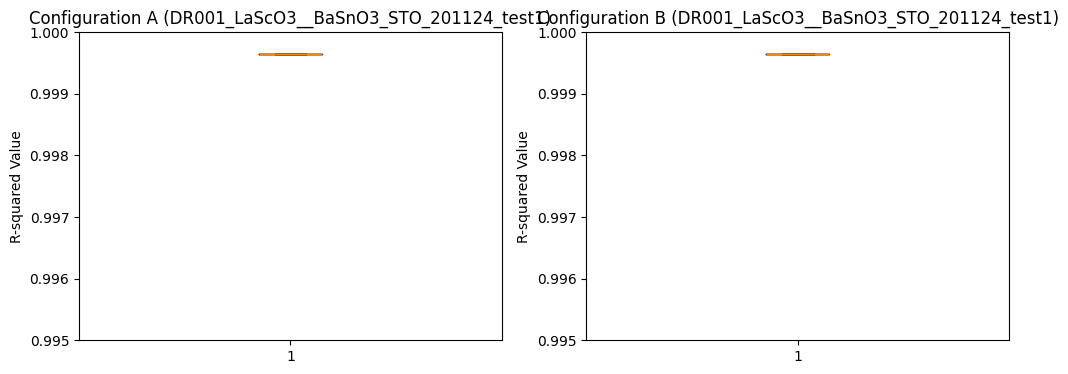

average R-squared_A for DR004_LaScO3__BaSnO3_STO_201124_combined3 = 0.9999997392035024
average R-squared_B for DR004_LaScO3__BaSnO3_STO_201124_combined3 = 0.9999997392035024


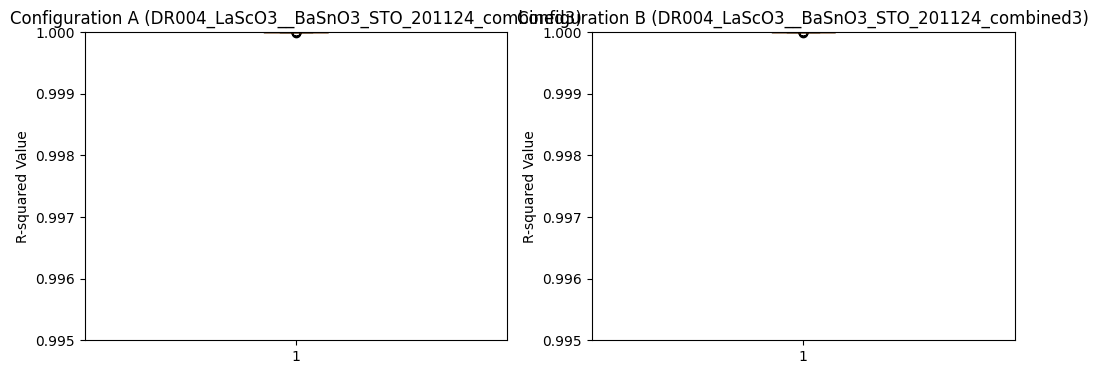

average R-squared_A for DR004_LaScO3__BaSnO3_STO_201124_combined4 = 0.9999996941629057
average R-squared_B for DR004_LaScO3__BaSnO3_STO_201124_combined4 = 0.9999996941629057


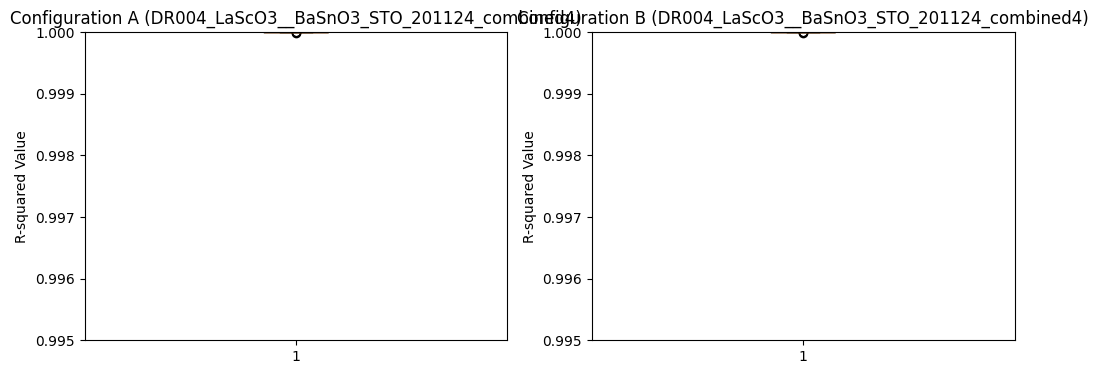

average R-squared_A for DR004_LaScO3__BaSnO3_STO_201124_test2 = 0.9999994854994172
average R-squared_B for DR004_LaScO3__BaSnO3_STO_201124_test2 = 0.9999994854994172


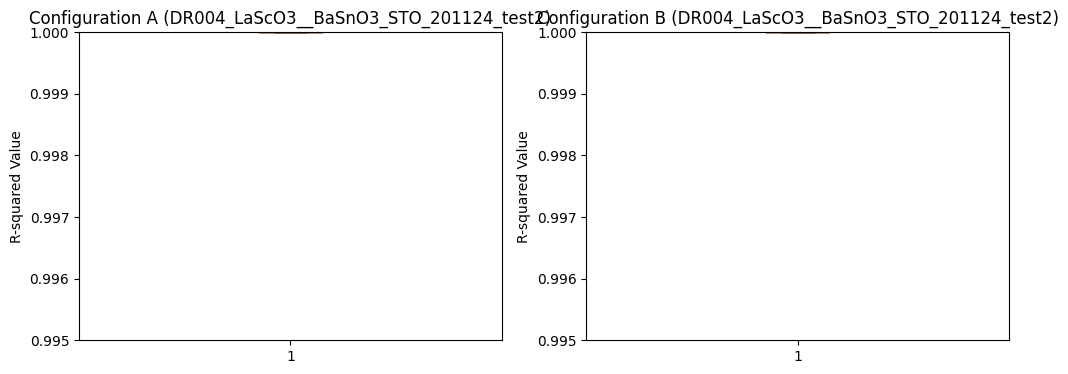

In [19]:
for d in dat:
    print(f'average R-squared_A for {d.filename} =', np.mean(np.abs(d.hall_data[:, 3])))
    print(f'average R-squared_B for {d.filename} =', np.mean(np.abs(d.hall_data[:, 5])))

    # Plot R-square values in a boxplot
    # Note that the y axis is showing the deviation in 1e-6 from the perfect value of 1 so generally the values are very close to 1
    fig11 = plt.figure(figsize=(12, 4))
    ax = fig11.add_subplot(121)
    ax.boxplot(np.abs(d.hall_data[:, 3]))
    ax.set_title(f'Configuration A ({d.filename})')
    ax.set_ylabel('R-squared Value')
    ax.set_ylim(1-5e-3, 1)  # If needed, you can set x-axis limits too

    ax2 = fig11.add_subplot(122)
    ax2.boxplot(np.abs(d.hall_data[:, 5]))
    ax2.set_title(f'Configuration B ({d.filename})')
    ax2.set_ylabel('R-squared Value')
    ax2.set_ylim(1-5e-3, 1)  # If needed, you can set x-axis limits too
    plt.show()

    if plot_data == True:
        fig11.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_R_squared_hall_res.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall resisitivity vs Temperature

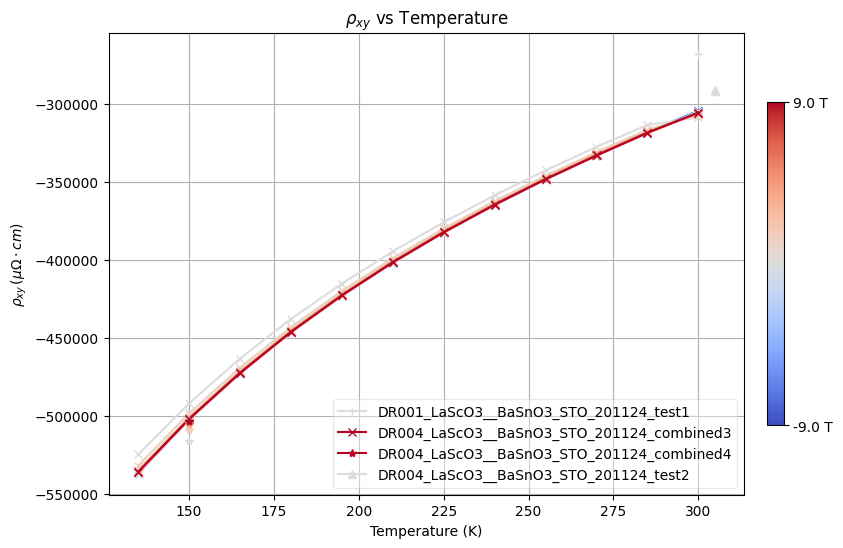

In [20]:
# Create a figure and axis
fig12 = plt.figure(figsize=(10, 6))
ax = fig12.add_subplot(111)  # Create a single subplot


for j, d in enumerate(dat):
    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    # higher field is brighter color in both cases
    cmap1 = plt.get_cmap('winter')(np.linspace(0, 1, int(d.ctf[5] / 2)))
    cmap2 = plt.get_cmap('winter_r')(np.linspace(0, 0.8, int(d.ctf[5] / 2)))
    c_val = np.vstack((cmap1, cmap2))

    
    for k in range(d.ctf[5]):
        # Plot rho_film vs Temp
        ax.plot(d.hall_data[k::d.ctf[5], 0], d.hall_data[k::d.ctf[5], 6] * 1e8, marker=mark_p[j], color= cmap_field(norm_field(d.hall_data[k, 1])))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(d.hall_data[k, 1])), label=f'{d.filename}')
        
# Set labels and title
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
ax.set_title(r'$\rho_{xy}$' f' vs Temperature')
# ax.set_xlim(0,100)
# ax.set_ylim(1425,1525)

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='lower right', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])

# Show the plot
plt.show()

if plot_data == True:
    fig12.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_T.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity vs Field

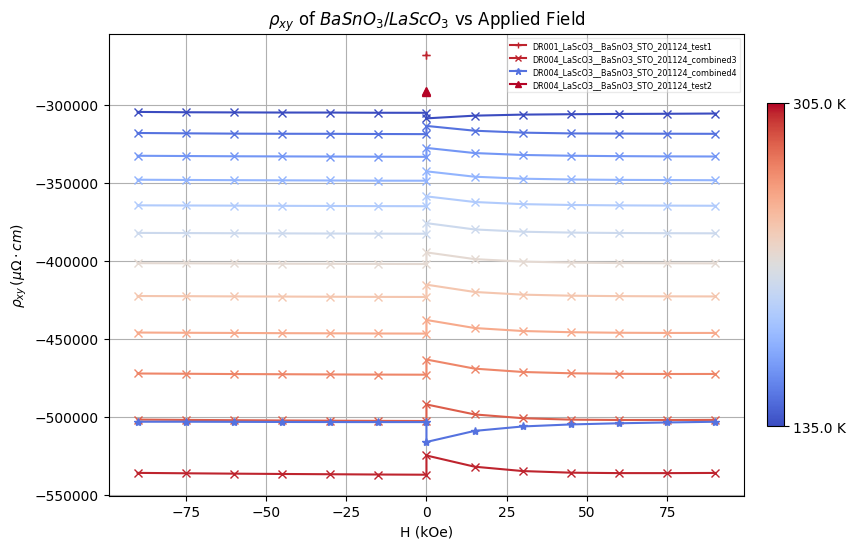

In [21]:
# Create a figure and axis
fig13 = plt.figure(figsize=(10, 6))
ax = fig13.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat):
    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    # higher field is brighter color in both cases
    c_val = plt.get_cmap('winter')(np.linspace(0, 1, int(d.ctf[5])))

    for t_count, t in enumerate(d.ctf[1], start=0):
        if t > 1:
            index = t_count * d.ctf[5]
            # Plot rho_film vs Temp
            ax.plot(d.hall_data[index:index+d.ctf[5], 1]*10, d.hall_data[index:index+d.ctf[5], 6]*1e8, marker=mark_p[j], color=cmap_temp(norm_temp(t)))
    
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(t)), label=f'{d.filename}')
    
# Set labels and title
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4, markerscale=0.8, fontsize='xx-small')

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

# Show the plot
plt.show()

if plot_data == True:
    fig13.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_field.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Resistivity vs Field - Offset removed

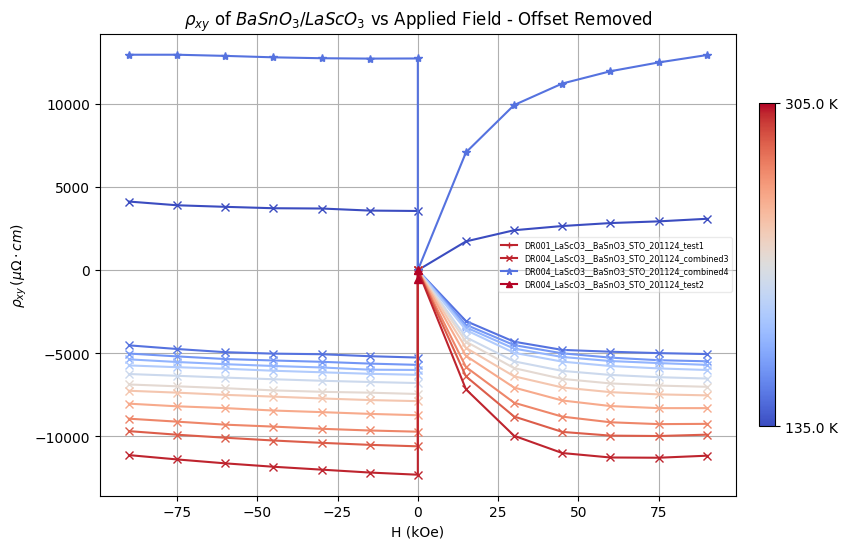

In [22]:
# Create a figure and axis
fig14 = plt.figure(figsize=(10, 6))
ax = fig14.add_subplot(111)  # Create a single subplot

# Create a secondary y-axis
#ax2 = ax.twinx()

# Loop over the data sets
for j, d in enumerate(dat, start=0):
    # Generating one set of colors for increasing positive field and one set for decreasing negative field
    # higher field is brighter color in both cases
    c_val = plt.get_cmap('winter')(np.linspace(0, 1, d.ctf[4]))



    for t_count, t in enumerate(d.ctf[1], start=0):
        if t > 1:
            index = t_count * d.ctf[5]
            # Plot rho_film vs Temp
            ax.plot(d.hall_data[index:index+d.ctf[5], 1]*10, (d.hall_data[index:index+d.ctf[5], 6]-d.hall_data[index+int(d.ctf[5]/2), 6])*1e8, marker=mark_p[j], color=cmap_temp(norm_temp(t)))
            #ax2.plot(d.ctf[2][:] * 10, d.mag_res[t_count, :, 2], color=cmap_temp(norm_temp(t)), linestyle=':')
    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_temp(norm_temp(t)), label=f'{d.filename}')
    
# Set labels and title
ax.set_xlabel('H (kOe)')
ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
ax.set_title(r'$\rho_{xy}$' f' of {d.material} vs Applied Field - Offset Removed')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4, markerscale=0.8, fontsize='xx-small')

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_temp, norm=norm_temp)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
#cbar.set_label('Temperature (K)')
cbar.set_ticks([min_temp, max_temp])
cbar.set_ticklabels([f'{min_temp:.1f} K', f'{max_temp:.1f} K'])

# Show the plot
plt.show()

if plot_data == True:
    fig14.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xy_vs_field_0offset.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Hall Coeff -> Charge Carrier Density Vs T

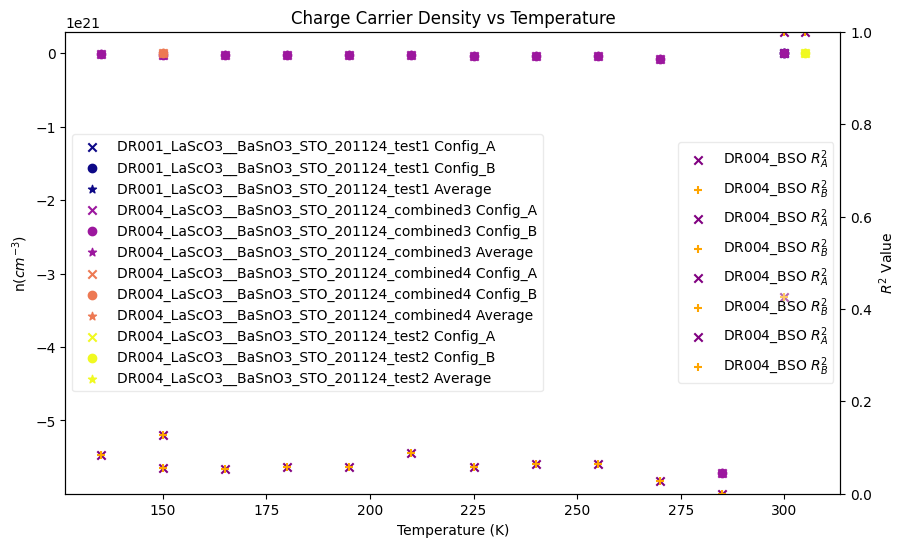

In [23]:
# Create a figure and axis
fig15 = plt.figure(figsize=(10, 6))
ax = fig15.add_subplot(111)  # Create a single subplot


# Create separate marker arrays for positive and negative fields stitched together
marker_hall = ['x', 'o', '*']

for j, d in enumerate(dat):
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(-1, np.multiply(d.hall_coefficient[:, 1], scipy.constants.e)), marker='x', color=cmap_dat[j], label=f'{d.filename} Config_A')
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(-1, np.multiply(d.hall_coefficient[:, 3], scipy.constants.e)), marker='o', color=cmap_dat[j], label=f'{d.filename} Config_B')
    ax.scatter(d.hall_coefficient[:, 0], 1e-6 * np.divide(-1, np.multiply(d.hall_coefficient[:, 5], scipy.constants.e)), marker='*', color=cmap_dat[j], label=f'{d.filename} Average')

# Set labels and title for the left y-axis
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'n($cm^{-3}$)')
ax.set_title(f'Charge Carrier Density vs Temperature')

# Add a grid
ax.grid(False)

# Add a legend for the left y-axis
ax.legend(loc='center left', framealpha=0.4)

# Create a second y-axis on the right
ax2 = ax.twinx()

# Plot data on the right y-axis
for j, d in enumerate(dat):
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 2]), color='purple', marker='x', label=f'{d.plot_str} $R^2_A$')
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 4]), color='orange', marker='+', label=f'{d.plot_str} $R^2_B$')

# Set labels for the right y-axis
ax2.set_ylabel('$R^2$ Value')

# Add a legend for the right y-axis
ax2.legend(loc='center right', framealpha=0.4)
ax2.set_ylim(0, 1)

#ax.set_xlim(0,76)

# Show the plot
plt.show()

if plot_data == True:
    fig15.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_n_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## Mobility vs T

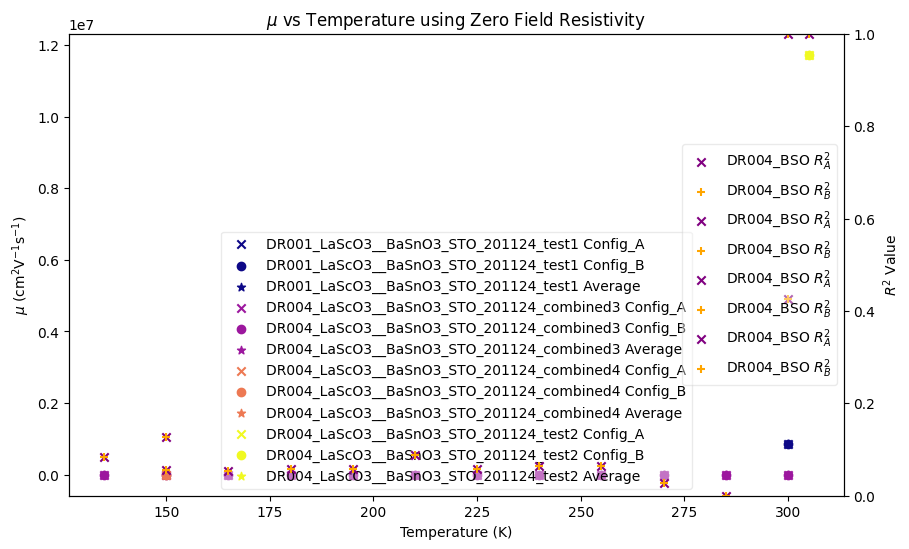

In [24]:
# Create a figure and axis
fig16 = plt.figure(figsize=(10, 6))
ax = fig16.add_subplot(111)  # Create a single subplot


for j, d in enumerate(dat, start=0):
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(-d.hall_coefficient[:, 1], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='x', color=cmap_dat[j], label=f'{d.filename} Config_A')
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(-d.hall_coefficient[:, 3], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='o', color=cmap_dat[j], label=f'{d.filename} Config_B')
    ax.scatter(d.hall_coefficient[:, 0], 1e4 * np.divide(-d.hall_coefficient[:, 5], d.res_data[int(d.ctf[5]/2-1)::d.ctf[5], 4]), marker='*', color=cmap_dat[j], label=f'{d.filename} Average')

# Set labels and title for the left y-axis
ax.set_xlabel('Temperature (K)')
ax.set_ylabel(r'$\mu$ (cm$^2$V$^{-1}$s$^{-1}$)')
ax.set_title(r'$\mu$' f' vs Temperature using Zero Field Resistivity')
#ax.set_ylim(-100, 0)

# Add a grid
ax.grid(False)

# Add a legend for the left y-axis
ax.legend(loc='lower center', framealpha=0.4)

# Create a second y-axis on the right
ax2 = ax.twinx()

# Plot data on the right y-axis
for d in dat:
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 2]), color='purple', marker='x', label=f'{d.plot_str} $R^2_A$')
    ax2.scatter(d.hall_coefficient[:, 0], np.abs(d.hall_coefficient[:, 4]), color='orange', marker='+', label=f'{d.plot_str} $R^2_B$')

# Set labels for the right y-axis
ax2.set_ylabel('$R^2$ Value')

# Add a legend for the right y-axis
ax2.legend(loc='center right', framealpha=0.4)
ax2.set_ylim(0, 1)

#ax.set_ylim(-50, 0)

# Show the plot
plt.show()

if plot_data == True:
    fig16.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_mobility_vs_temperature.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


## $\rho_{xy}$ vs $\rho_{xx}$
- Can have problems where with both holes and electrons the carriers can cancel out the measured hall voltage
- Need to check this?

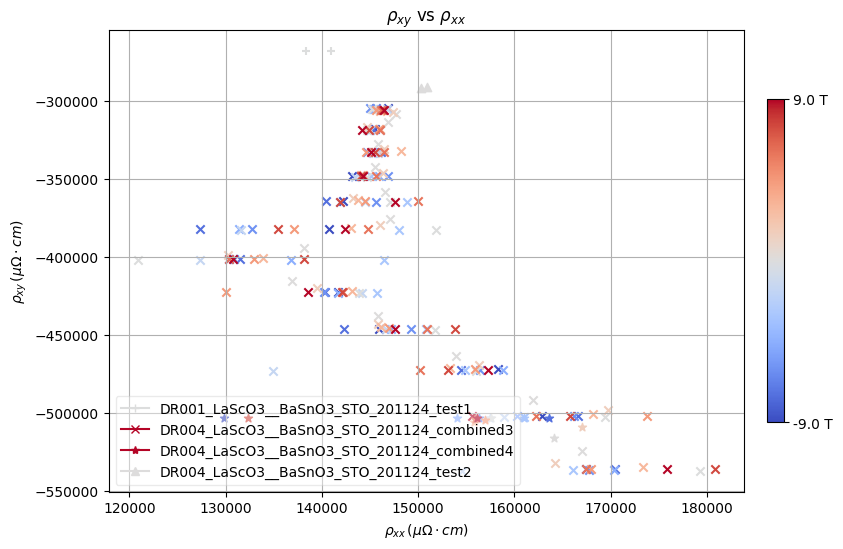

In [25]:
# Create a figure and axis
fig17 = plt.figure(figsize=(10, 6))
ax = fig17.add_subplot(111)  # Create a single subplot

# Loop over the data sets
for j, d in enumerate(dat, start=0):
    # Generate color map
    c_val = plt.get_cmap('winter')(np.linspace(0, 1, d.ctf[5]))


    for H_count, H in enumerate(d.ctf[2], start=0):
        # Plot rho_film vs Temp
        ax.scatter(d.res_data[H_count::d.ctf[5], 4] * 1e8, d.hall_data[H_count::d.ctf[5], 6] * 1e8, marker=mark_p[j], color=cmap_field(norm_field(H)))

    # Add a dummy plot for the legend entry
    ax.plot([], [], marker = mark_p[j], color = cmap_field(norm_field(H)), label=f'{d.filename}')
    
ax.set_ylabel(r'$\rho_{xy}\,(\mu \Omega \cdot cm)$')
ax.set_xlabel(r'$\rho_{xx}\,(\mu \Omega \cdot cm)$')
ax.set_title(r'$\rho_{xy}$ vs $\rho_{xx}$')

# Add a grid
ax.grid(True)

# Add a legend
ax.legend(loc='best', framealpha=0.4)

# Create a ScalarMappable and add a colorbar
sm = ScalarMappable(cmap=cmap_field, norm=norm_field)
cbar = plt.colorbar(sm, ax=ax,  pad=0.03, shrink=0.7)
cbar.set_ticks([min_field, max_field])
cbar.set_ticklabels([f'{min_field:.1f} T', f'{max_field:.1f} T'])

# Show the plot
plt.show()

if plot_data == True:
    fig17.savefig(dat[0].directory.joinpath(f'{dat[0].plot_str}_rho_xx_vs_rho_xy.{fig_format}'), dpi=300, bbox_inches='tight', transparent=plot_transparency)


In [26]:
#powerpoint_data=True
if powerpoint_data == True:
    # Create a PowerPoint presentation object
    prs = Presentation()

    # Define a function to add a slide with a title and image
    def add_slide(prs, title, fig):
        slide_layout = prs.slide_layouts[5]  # Use a blank slide layout
        slide = prs.slides.add_slide(slide_layout)
        
        # Set background color with 40% transparency
        background = slide.background
        fill = background.fill
        fill.solid()
        fill.fore_color.rgb = RGBColor(200, 200, 200)

        # Add title with custom font
        title_shape = slide.shapes.title
        title_shape.text = title
        title_shape.text_frame.paragraphs[0].font.size = Pt(24)
        title_shape.text_frame.paragraphs[0].font.bold = True
        title_shape.text_frame.paragraphs[0].font.color.rgb = RGBColor(0, 0, 0)
        title_shape.text_frame.paragraphs[0].font.name = 'Arial'
        title_shape.text_frame.paragraphs[0].alignment = PP_ALIGN.CENTER

        # Save the figure as an image
        img_path = f"{title}.png"
        fig.savefig(img_path, dpi=300, bbox_inches='tight', transparent=True)

        
         # Calculate the left position to center the image
        slide_width = prs.slide_width
        image_width = Inches(8)
        left = (slide_width - image_width) / 2
        top = Inches(2)  # Position the figure lower down by 2 inches
        
        # Add the image to the slide
        pic = slide.shapes.add_picture(img_path, left, top, width=image_width)

    # List of figures and their corresponding titles
    figures = [
        (fig1, "Plot IV data from Resistivity Measurement to Check Linearity"),
        (fig2, "R-squared Analysis to Check Linearity of I-V Resistivity data"),
        (fig3, "Resistivity Configuration Compararison"),
        (fig4, "Resistivity vs Temperature"),
        (fig5, "Resistivity vs H"),
        (fig6, "Magnetoresistance vs H"),
        (fig7, "Magnetoresistance Vs T"),
        (fig8, "Arhenius Plot"),
        (fig9, "Log(R) vs Log(T)"),
        (fig10, "Plot IV data of Hall Measurement to Check Linearity"),
        (fig11, "R-squared Analysis to Check Linearity of Resistivity I-V data"),
        (fig12, "Hall resisitivity vs Temperature"),
        (fig13, "Hall resisitivity vs Applied Field"),
        (fig14, "Hall resisitivity vs Applied Field - Offset Removed"),
        (fig15, "Charge Carrier Density Vs T"),
        (fig16, "Mobility vs T"),
        (fig17, "ρ_xy vs ρ_xx"),
        
        
    ]

    # Add each figure to the PowerPoint presentation
    for fig, title in figures:
        add_slide(prs, title, fig)

    # Save the PowerPoint presentation
    prs.save(dat[0].directory.joinpath(f'{dat[0].plot_str}_figures.pptx'))